## Proof of Concept for flood maps

This notebook is an attempt at translating the CoCliCo User Story into code. 

The data used is Coastal Flood Hazard Projections and can be found here: p:\11207608-coclico\FULLTRACK_DATA\WP4\

In [3]:
# Import modules

import warnings

# import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import shapely
import pandas as pd
import pystac_client
import xarray as xr
import rioxarray as rio
import pathlib
import pystac
import pystac_client
import geopandas as gpd

#import colormaps as cmaps
import pyam # https://pyam-iamc.readthedocs.io/en/latest/index.html
import matplotlib.colors as mcolors

from copy import deepcopy
from typing import List, Dict

# ignore warnings
warnings.filterwarnings("ignore")

C:\Users\soest\AppData\Local\Temp\ipykernel_13372\3396277978.py:19: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [4]:
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-cfhp/catalog.json"
)
collection = catalog.get_child(id = 'cfhp')

In [5]:
# Load LAU's 

# Set file path
lau_fp = r"p:\11207608-coclico\FASTTRACK_DATA\XX_LAU\LAU_RG_01M_2020_3035.shp"

# Load data
lau_data = gpd.read_file(lau_fp)

<Axes: >

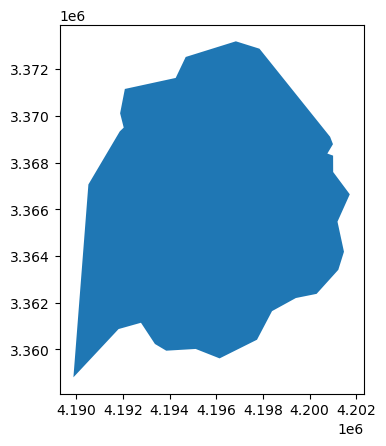

In [6]:
# Filter on the Netherlands as an example
lau_NL = lau_data.loc[lau_data["CNTR_CODE"] == "NL"] 

# Select one for testing
lau = lau_data.loc[lau_data["LAU_NAME"] == "Varel, Stadt"] 

lau.plot()

In [11]:
# intersecting_items = []
# for item in collection.get_items():
#     item_geometry = item.geometry
#     if item_geometry.intersects(lau['geometry'].unary_union):
#         intersecting_items.append(item)

AttributeError: 'dict' object has no attribute 'intersects'

In [26]:
for i, item in enumerate(collection.get_all_items()):
    
    if "UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=4005362_y=2958337.tif" in item.id:
        print(item.id)
        print(i)
        break


UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=4005362_y=2958337.tif
918


In [27]:
from shapely.geometry import shape

cur_item_geom = gpd.GeoDataFrame(geometry=[shape(item.geometry)])

[item_geom] = item.properties['proj:geometry']['coordinates']


In [28]:
item

<Item id=UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=4005362_y=2958337.tif>

POLYGON ((4201005.0361 3368299.9952, 4201007.7024 3367599.5951, 4201719.2838 3366644.43, 4201193.0196 3365472.5880999994, 4201470.5206 3364184.231899999, 4201228.1226 3363410.9146, 4200298.259099999 3362381.0622, 4199410.7407 3362202.613399999, 4198390.0134 3361642.2984999996, 4197746.759099999 3360417.4098, 4196144.7213 3359618.0276999995, 4195120.8894 3360022.1556, 4193859.4793 3359947.4679, 4193375.8833 3360235.0918, 4192777.8575 3361143.5722, 4191818.4787 3360874.0624, 4189885.0845999997 3358807.5512, 4190526.6800999995 3367065.3516, 4191871.2693 3369338.8476, 4192038.9671 3369500.6525, 4191884.8652999997 3370113.9671, 4192087.6810999997 3371155.1555, 4194264.6788 3371627.3175, 4194693.4284 3372525.211, 4196841.2299 3373195.6117, 4197851.884299999 3372879.2695, 4200877.5053 3369106.0669, 4200999.148 3368790.8762, 4200758.7431 3368388.8255, 4201005.0361 3368299.9952))
0    POLYGON ((4824550.000 2958325.000, 4824550.000...
Name: geometry, dtype: geometry
Working on: Varel, Stadt


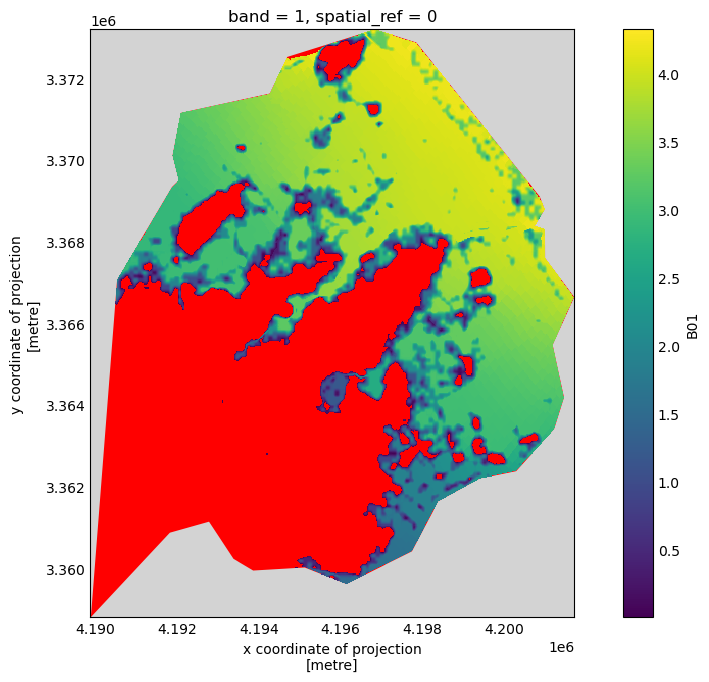

In [29]:
item_test = gpd.GeoDataFrame(geometry = [shapely.Polygon(item_geom)])

# Generate figure
f, ax = plt.subplots(figsize=(10, 6))
item_test.plot(ax=ax, color='lightgray', edgecolor='black')
lau_NL.plot(ax=ax, color='blue', edgecolor='black')
lau.plot(ax=ax, color='red')


for i, cur_lau in lau.iterrows():
    
    if cur_lau['geometry'].intersects(item_test['geometry'])[0]:

        print(cur_lau['geometry'])
        print(item_test['geometry'])
        
        print('Working on: ' + str(cur_lau['LAU_NAME']))
        # Load raw band_data dataset 
        ds = rio.open_rasterio(item.assets['band_data'].href)

        # Clip dataset to match AOI
        ds_clip = ds.rio.clip(cur_lau)

        del ds

# Adjust FillValue (NoData) to np.nan for plotting purposes
ds_clip = ds_clip.where(ds_clip != ds_clip.attrs['_FillValue'],np.nan)
# Plot data
ds_clip.plot(ax=ax)

del ds_clip

In [18]:
# Compute statistics

# Amount of noData's within dataset clipped to polygon
class flood_stats:
    def __init__(self):
        
        # Intialize empty lists
        self.all_nans = []
        self.all_less05 = []
        self.all_more05 = []
        self.all_total = []

    def compute(self,ds):

        self.ds = ds

        self.n_nans = np.isnan(self.ds.values).sum()
        self.n_less05 = np.array([self.ds.values<0.5]).sum()
        self.n_more05 = np.array([self.ds.values>0.5]).sum()

        self.total = self.n_nans + self.n_less05 + self.n_more05

    def add_new_values(self):

        # Append values to lists
        self.all_nans.append(self.n_nans)
        self.all_less05.append(self.n_less05)
        self.all_more05.append(self.n_more05)
        self.all_total.append(self.total)
        
    def convert2arrays(self):

        self.all_nans = np.array(self.all_nans)
        self.all_less05 = np.array(self.all_less05)
        self.all_more05 = np.array(self.all_more05)
        self.all_total = np.array(self.all_total)

if __name__ == '__main__':
    
    clip_stats = flood_stats()
    clip_stats.compute(ds_clip)

    print('summed pixels = ' + str(clip_stats.total))
    print('original pixels = ' + str(np.size(ds_clip.values)))

TypeError: flood_stats.__init__() takes 1 positional argument but 2 were given

NameError: name 'n_nans' is not defined

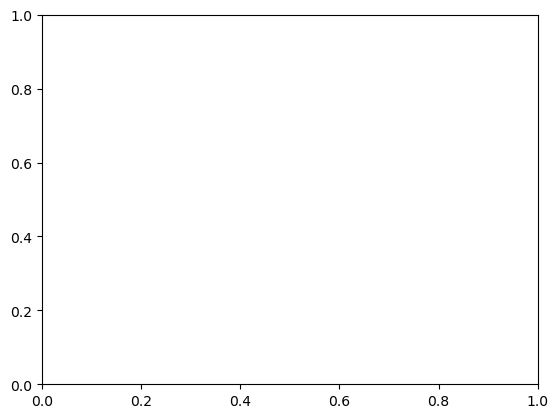

In [19]:
# Plot data
import matplotlib.pyplot as plt

# Set labels
labels = 'no flooding','flooding < 0.5m', 'flooding > 0.5m'
# Initiate figure
fig, ax = plt.subplots()
# Do plotting
ax.pie(np.array([n_nans,n_less05,n_more05]), labels = labels)
ax.set_title('Percentage flooded = ' + str(round((n_less05+n_more05)/n_nans*100)) + '%')

In [20]:
import os

# Set up folder structure
folder_structure = {
    "Mean_spring_tide": [],
    "RP": ["1000", "100", "1"],
    "SLR": {
        "High_end": ["2100", "2150"],
        "SSP126": ["2100"],
        "SSP245": ["2050", "2100"],
        "SSP585": ["2030", "2050", "2100"]
    }
}

def get_paths(folder_structure, base_dir=''):
    """Generate paths for a folder structure defined by a dict"""
    paths = []
    for key, value in folder_structure.items():
        if isinstance(value, dict):
            paths.extend(get_paths(value, os.path.join(base_dir, key)))
        elif isinstance(value, list):
            if value:
                for item in value:
                    if item != "":
                        paths.append(os.path.join(base_dir, key, item))
            else:
                paths.append(os.path.join(base_dir, key))
        else:
            continue
    return paths

map_types = ["HIGH_DEFENDED_MAPS", "LOW_DEFENDED_MAPS", "UNDEFENDED_MAPS"]

path_list = get_paths(folder_structure)
path_list


['Mean_spring_tide',
 'RP\\1000',
 'RP\\100',
 'RP\\1',
 'SLR\\High_end\\2100',
 'SLR\\High_end\\2150',
 'SLR\\SSP126\\2100',
 'SLR\\SSP245\\2050',
 'SLR\\SSP245\\2100',
 'SLR\\SSP585\\2030',
 'SLR\\SSP585\\2050',
 'SLR\\SSP585\\2100']

In [21]:
# Load all scenarios
from pathlib import Path
import time

start_time = time.time()

# Initialize flood stats class
clip_stats = flood_stats()
all_fps = []

for item in collection.get_all_items():
    # NOTE: for now only focus on low_defended map_type
    if map_types[1] in item.id and 'SLR' in str(item.id):

        # Get item bounding box geometry
        [item_boundbox] = item.properties['proj:geometry']['coordinates']
        # Transform bounding box coordinates to GeoDataFrame Polygon
        item_boundbox = gpd.GeoDataFrame(geometry = [shapely.Polygon(item_boundbox)])
        
        # Check if lau intersects with item bounding box
        if cur_lau.geometry.intersects(item_boundbox.geometry)[0]:
    
            print('Working on: ' + str(item.id))

            # Load raw band_data dataset 
            ds = rio.open_rasterio(item.assets['band_data'].href)

            # Clip dataset to match AOI
            ds_clip = ds.rio.clip(cur_lau)

            # Adjust FillValue (NoData) to np.nan for plotting and processing purposes
            ds_clip = ds_clip.where(ds_clip != ds_clip.attrs['_FillValue'],np.nan)
                # print("--- %s seconds ---" % (time.time() - start_time))

            # Close dataset to save memory
            del ds

    	    # Compute flood statistics for each floop_maps
            clip_stats.compute(ds_clip)
            clip_stats.add_new_values()

            # Collect all filepaths
            all_fps.append(item.id)

clip_stats.convert2arrays()


Working on: LOW_DEFENDED_MAPS/SLR/High_end/2100/B01_epsg=3035_x=4005362_y=2958337.tif
Working on: LOW_DEFENDED_MAPS/SLR/High_end/2150/B01_epsg=3035_x=4005362_y=2958337.tif
Working on: LOW_DEFENDED_MAPS/SLR/SSP126/2100/B01_epsg=3035_x=4005362_y=2958337.tif
Working on: LOW_DEFENDED_MAPS/SLR/SSP245/2050/B01_epsg=3035_x=3743687_y=2958337.tif
Working on: LOW_DEFENDED_MAPS/SLR/SSP245/2100/B01_epsg=3035_x=4005362_y=2958337.tif
Working on: LOW_DEFENDED_MAPS/SLR/SSP585/2030/B01_epsg=3035_x=3743687_y=2958337.tif
Working on: LOW_DEFENDED_MAPS/SLR/SSP585/2050/B01_epsg=3035_x=3743687_y=2958337.tif
Working on: LOW_DEFENDED_MAPS/SLR/SSP585/2100/B01_epsg=3035_x=4005362_y=2958337.tif


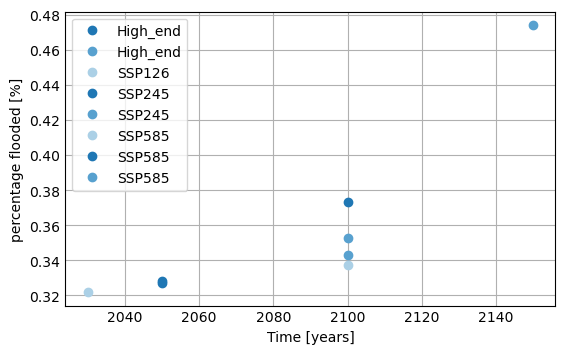

In [23]:
# Convert list of paths to pathlib
fps = [Path(fp) for fp in all_fps]

fig, ax = plt.subplots(figsize=(5,3))

color = []

scen = []
year = np.array([])

flooded = np.divide(np.add(clip_stats.all_less05, clip_stats.all_more05),clip_stats.all_total)

for i, fp in enumerate(fps):

    scen.append(fp.parts[2])
    year = np.append(year, int(fp.parts[-2]))
    
    ax.plot(year[i],flooded[i],'o')
    ax.set_xlabel('Time [years]')
    ax.set_ylabel('percentage flooded [%]')
ax.legend(scen)